In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [40]:
SEQ_LEN = 180
EPOCHS = 500
FUTURE_PERIOD_PREDICT = 10
TO_PREDICT = "MOTA"
BATCH_SIZE = 64
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

def interpolate_gaps(values, limit=None):
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])
    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan
    return filled

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
# df2['Tandoori'] = interpolate_gaps(df2.Tandoori, limit=2)
# df2['Tandoori_Smooth'] = smooth_curve(df2.Tandoori.values)

In [3]:
df1 = pd.read_csv('delhi_market.csv')
df1.index = df1.Date
df1 = df1[['MOTA (1.8','MEDIUM','TANDURI','VEHICLE']]
df1.columns = ['MOTA', 'MEDIUM', 'TANDURI', 'VEHICLE']

In [4]:
df2 = pd.read_csv('gujrat_mumbai_punjab.csv')
df2.index = df2.Date
df2 = df2[['GUJRAT','MUMBAI','PUNJAB']]

In [63]:
#removing outlier
# aa = df.MEDIUM.replace({' ':np.NaN}).astype('float')
# aa[aa>150]
df = pd.concat([df1,df2],axis= 1)
df['MEDIUM'] = df.MEDIUM.replace({'7500104':'75'})
df['VEHICLE'] = df.VEHICLE.replace({'140140':'140','645':'65','1115':'115','1325':'135'})
df = df.replace({' ':np.NaN}).astype('float')
for col in df:
    df[col] = interpolate_gaps(df[col], limit=3)

In [21]:
pred_chicken = df[TO_PREDICT]
label = [pred_chicken[i+1:i+FUTURE_PERIOD_PREDICT + 1].mean() for i in range(len(df)-FUTURE_PERIOD_PREDICT)]
next_10 = [62,62.15,62.65,62.65,63.05,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]
label = label+next_10

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
df['target'] = label
df = df.dropna()

In [62]:
df
# validation_df = df.iloc[-130:]
# train_df = df.iloc[:-130]

,MOTA,MEDIUM,TANDURI,VEHICLE,GUJRAT,MUMBAI,PUNJAB,target
0,0.120482,0.083333,0.043956,0.442724,0.0875,0.192308,0.098765,56.15
1,0.132530,0.107143,0.065934,0.349845,0.0625,0.166667,0.098765,56.85
2,0.126506,0.107143,0.065934,0.365325,0.0625,0.115385,0.098765,57.60
3,0.120482,0.107143,0.065934,0.380805,0.0250,0.076923,0.086420,58.00
4,0.096386,0.083333,0.043956,0.256966,0.0625,0.076923,0.098765,59.00
5,0.096386,0.083333,0.043956,0.256966,0.1500,0.166667,0.086420,60.30
6,0.168675,0.083333,0.131868,0.287926,0.1375,0.179487,0.135802,61.10
7,0.168675,0.142857,0.120879,0.411765,0.1250,0.166667,0.135802,62.00
8,0.289157,0.261905,0.285714,0.287926,0.1125,0.166667,0.222222,61.60
9,0.265060,0.244048,0.230769,0.349845,0.1500,0.179487,0.259259,61.40


In [42]:
sequential_data = []
prev_days = deque(maxlen=SEQ_LEN)
for i in df.values:
    prev_days.append([n for n in i[:-1]])
    if len(prev_days) == SEQ_LEN:
        sequential_data.append([np.array(prev_days), i[-1]])
train_seq = sequential_data[:-115]
validation_seq = sequential_data[-115:]
random.shuffle(train_seq)
random.shuffle(validation_seq)

In [43]:
X_train, y_train, X_val, y_val = [],[],[],[]

for seq, target in train_seq:
    X_train.append(seq)
    y_train.append(target)

for seq, target in validation_seq:
    X_val.append(seq)
    y_val.append(target)
    
X_train = np.array(X_train)
X_val = np.array(X_val)

In [44]:
X_train.shape

(2166, 180, 7)

In [45]:
model = Sequential()
model.add(CuDNNLSTM(256, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256, return_sequences=True))
# model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

In [46]:
opt = tf.keras.optimizers.Adam(lr=0.0005, decay=1e-6)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
# tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

# filepath = "RNN_Final-{epoch:02d}-{val_mean_absolute_error:.3f}"
# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='max'))

In [47]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

score = model.evaluate(X_val, y_val, verbose=0)
# print('Test loss:', score[0])
# print('Test mae:', score[1])
# # model.save("models/{}".format(NAME))

Train on 2166 samples, validate on 115 samples
Epoch 1/500
2166/2166 [==============================] - 14s 6ms/step - loss: 4759.7076 - mean_absolute_error: 68.0013 - val_loss: 3822.2525 - val_mean_absolute_error: 59.7760
Epoch 2/500
2166/2166 [==============================] - 11s 5ms/step - loss: 2871.4492 - mean_absolute_error: 52.2070 - val_loss: 2644.5660 - val_mean_absolute_error: 48.8819
Epoch 3/500
2166/2166 [==============================] - 11s 5ms/step - loss: 1806.4883 - mean_absolute_error: 38.9662 - val_loss: 1231.6674 - val_mean_absolute_error: 31.2209
Epoch 4/500
2166/2166 [==============================] - 11s 5ms/step - loss: 723.0098 - mean_absolute_error: 22.3856 - val_loss: 867.3796 - val_mean_absolute_error: 25.2176
Epoch 5/500
2166/2166 [==============================] - 11s 5ms/step - loss: 845.7469 - mean_absolute_error: 23.1506 - val_loss: 298.0906 - val_mean_absolute_error: 13.2204
Epoch 6/500
2166/2166 [==============================] - 11s 5ms/step - loss:

Epoch 48/500
2166/2166 [==============================] - 11s 5ms/step - loss: 200.6186 - mean_absolute_error: 11.1960 - val_loss: 31.4207 - val_mean_absolute_error: 4.4192
Epoch 49/500
2166/2166 [==============================] - 11s 5ms/step - loss: 150.4865 - mean_absolute_error: 9.6132 - val_loss: 27.1962 - val_mean_absolute_error: 4.1497
Epoch 50/500
2166/2166 [==============================] - 11s 5ms/step - loss: 183.1918 - mean_absolute_error: 10.7415 - val_loss: 35.6893 - val_mean_absolute_error: 4.5561
Epoch 51/500
2166/2166 [==============================] - 11s 5ms/step - loss: 177.6220 - mean_absolute_error: 10.3893 - val_loss: 35.4884 - val_mean_absolute_error: 4.7949
Epoch 52/500
2166/2166 [==============================] - 11s 5ms/step - loss: 160.9470 - mean_absolute_error: 9.9823 - val_loss: 37.9766 - val_mean_absolute_error: 5.1536
Epoch 53/500
2166/2166 [==============================] - 11s 5ms/step - loss: 201.0780 - mean_absolute_error: 11.0445 - val_loss: 41.481

2166/2166 [==============================] - 11s 5ms/step - loss: 92.2435 - mean_absolute_error: 7.5231 - val_loss: 75.0102 - val_mean_absolute_error: 7.5407
Epoch 96/500
2166/2166 [==============================] - 11s 5ms/step - loss: 83.3618 - mean_absolute_error: 7.2243 - val_loss: 114.1021 - val_mean_absolute_error: 9.5792
Epoch 97/500
2166/2166 [==============================] - 11s 5ms/step - loss: 92.3163 - mean_absolute_error: 7.5423 - val_loss: 88.2552 - val_mean_absolute_error: 7.8047
Epoch 98/500
2166/2166 [==============================] - 11s 5ms/step - loss: 87.9156 - mean_absolute_error: 7.3597 - val_loss: 108.7740 - val_mean_absolute_error: 7.5311
Epoch 99/500
2166/2166 [==============================] - 11s 5ms/step - loss: 81.8309 - mean_absolute_error: 7.1081 - val_loss: 65.3751 - val_mean_absolute_error: 6.3988
Epoch 100/500
2166/2166 [==============================] - 11s 5ms/step - loss: 86.0327 - mean_absolute_error: 7.3282 - val_loss: 65.7734 - val_mean_absolut

Epoch 143/500
2166/2166 [==============================] - 11s 5ms/step - loss: 69.0682 - mean_absolute_error: 6.4590 - val_loss: 87.0700 - val_mean_absolute_error: 8.5653
Epoch 144/500
2166/2166 [==============================] - 11s 5ms/step - loss: 67.7215 - mean_absolute_error: 6.3797 - val_loss: 88.8560 - val_mean_absolute_error: 7.3711
Epoch 145/500
2166/2166 [==============================] - 11s 5ms/step - loss: 66.2193 - mean_absolute_error: 6.3637 - val_loss: 66.8423 - val_mean_absolute_error: 6.6300
Epoch 146/500
2166/2166 [==============================] - 11s 5ms/step - loss: 65.7663 - mean_absolute_error: 6.2901 - val_loss: 77.0432 - val_mean_absolute_error: 7.2404
Epoch 147/500
2166/2166 [==============================] - 11s 5ms/step - loss: 62.2753 - mean_absolute_error: 6.1888 - val_loss: 146.6932 - val_mean_absolute_error: 9.8931
Epoch 148/500
2166/2166 [==============================] - 11s 5ms/step - loss: 69.6808 - mean_absolute_error: 6.5838 - val_loss: 100.4079 

2166/2166 [==============================] - 11s 5ms/step - loss: 53.3329 - mean_absolute_error: 5.6966 - val_loss: 78.5957 - val_mean_absolute_error: 7.7708
Epoch 191/500
2166/2166 [==============================] - 11s 5ms/step - loss: 55.9029 - mean_absolute_error: 5.8442 - val_loss: 77.3092 - val_mean_absolute_error: 7.7816
Epoch 192/500
2166/2166 [==============================] - 11s 5ms/step - loss: 59.8195 - mean_absolute_error: 6.0122 - val_loss: 79.2281 - val_mean_absolute_error: 7.5847
Epoch 193/500
2166/2166 [==============================] - 11s 5ms/step - loss: 57.6276 - mean_absolute_error: 5.9612 - val_loss: 86.0823 - val_mean_absolute_error: 8.0591
Epoch 194/500
2166/2166 [==============================] - 11s 5ms/step - loss: 59.9720 - mean_absolute_error: 5.9744 - val_loss: 60.5343 - val_mean_absolute_error: 6.4136
Epoch 195/500
2166/2166 [==============================] - 11s 5ms/step - loss: 56.9995 - mean_absolute_error: 5.9890 - val_loss: 140.5735 - val_mean_abso

Epoch 238/500
2166/2166 [==============================] - 11s 5ms/step - loss: 48.3410 - mean_absolute_error: 5.4494 - val_loss: 56.1490 - val_mean_absolute_error: 6.0088
Epoch 239/500
2166/2166 [==============================] - 11s 5ms/step - loss: 48.1639 - mean_absolute_error: 5.4481 - val_loss: 81.4483 - val_mean_absolute_error: 7.2831
Epoch 240/500
2166/2166 [==============================] - 11s 5ms/step - loss: 49.1066 - mean_absolute_error: 5.5060 - val_loss: 59.7363 - val_mean_absolute_error: 6.5063
Epoch 241/500
2166/2166 [==============================] - 11s 5ms/step - loss: 49.5027 - mean_absolute_error: 5.5474 - val_loss: 52.1407 - val_mean_absolute_error: 6.0564
Epoch 242/500
2166/2166 [==============================] - 11s 5ms/step - loss: 51.0211 - mean_absolute_error: 5.6126 - val_loss: 38.7999 - val_mean_absolute_error: 5.0944
Epoch 243/500
2166/2166 [==============================] - 11s 5ms/step - loss: 47.0265 - mean_absolute_error: 5.3680 - val_loss: 83.3155 - 

2166/2166 [==============================] - 11s 5ms/step - loss: 46.9480 - mean_absolute_error: 5.4631 - val_loss: 50.3669 - val_mean_absolute_error: 5.8569
Epoch 286/500
2166/2166 [==============================] - 11s 5ms/step - loss: 47.7494 - mean_absolute_error: 5.4514 - val_loss: 66.9361 - val_mean_absolute_error: 7.2454
Epoch 287/500
2166/2166 [==============================] - 11s 5ms/step - loss: 44.1096 - mean_absolute_error: 5.2040 - val_loss: 79.4492 - val_mean_absolute_error: 7.7668
Epoch 288/500
2166/2166 [==============================] - 11s 5ms/step - loss: 43.1206 - mean_absolute_error: 5.1327 - val_loss: 79.2149 - val_mean_absolute_error: 7.6738
Epoch 289/500
2166/2166 [==============================] - 11s 5ms/step - loss: 47.8960 - mean_absolute_error: 5.4448 - val_loss: 65.2304 - val_mean_absolute_error: 6.2056
Epoch 290/500
2166/2166 [==============================] - 11s 5ms/step - loss: 45.4761 - mean_absolute_error: 5.3051 - val_loss: 73.8695 - val_mean_absol

Epoch 333/500
2166/2166 [==============================] - 11s 5ms/step - loss: 39.5659 - mean_absolute_error: 4.9591 - val_loss: 54.8230 - val_mean_absolute_error: 5.8837
Epoch 334/500
2166/2166 [==============================] - 11s 5ms/step - loss: 39.5948 - mean_absolute_error: 4.9544 - val_loss: 48.5007 - val_mean_absolute_error: 5.5889
Epoch 335/500
2166/2166 [==============================] - 11s 5ms/step - loss: 39.2316 - mean_absolute_error: 4.9212 - val_loss: 59.5898 - val_mean_absolute_error: 6.6710
Epoch 336/500
2166/2166 [==============================] - 11s 5ms/step - loss: 39.4682 - mean_absolute_error: 4.9460 - val_loss: 53.3257 - val_mean_absolute_error: 6.3452
Epoch 337/500
2166/2166 [==============================] - 11s 5ms/step - loss: 39.0164 - mean_absolute_error: 4.9515 - val_loss: 42.2080 - val_mean_absolute_error: 5.5093
Epoch 338/500
2166/2166 [==============================] - 11s 5ms/step - loss: 37.8458 - mean_absolute_error: 4.8920 - val_loss: 49.7139 - 

2166/2166 [==============================] - 11s 5ms/step - loss: 38.2830 - mean_absolute_error: 4.9440 - val_loss: 66.6277 - val_mean_absolute_error: 6.4627
Epoch 381/500
2166/2166 [==============================] - 11s 5ms/step - loss: 36.0676 - mean_absolute_error: 4.7819 - val_loss: 63.6216 - val_mean_absolute_error: 5.9476
Epoch 382/500
2166/2166 [==============================] - 11s 5ms/step - loss: 37.6166 - mean_absolute_error: 4.8320 - val_loss: 56.0602 - val_mean_absolute_error: 5.9204
Epoch 383/500
2166/2166 [==============================] - 11s 5ms/step - loss: 36.2396 - mean_absolute_error: 4.7489 - val_loss: 57.5677 - val_mean_absolute_error: 5.9162
Epoch 384/500
2166/2166 [==============================] - 11s 5ms/step - loss: 38.1490 - mean_absolute_error: 4.8250 - val_loss: 66.0004 - val_mean_absolute_error: 6.4525
Epoch 385/500
2166/2166 [==============================] - 11s 5ms/step - loss: 34.5435 - mean_absolute_error: 4.6814 - val_loss: 73.8440 - val_mean_absol

Epoch 428/500
2166/2166 [==============================] - 11s 5ms/step - loss: 36.0458 - mean_absolute_error: 4.7667 - val_loss: 77.8737 - val_mean_absolute_error: 7.3473
Epoch 429/500
2166/2166 [==============================] - 11s 5ms/step - loss: 36.1224 - mean_absolute_error: 4.7509 - val_loss: 81.5851 - val_mean_absolute_error: 7.3974
Epoch 430/500
2166/2166 [==============================] - 11s 5ms/step - loss: 36.9208 - mean_absolute_error: 4.8247 - val_loss: 60.0910 - val_mean_absolute_error: 5.9888
Epoch 431/500
2166/2166 [==============================] - 11s 5ms/step - loss: 35.7591 - mean_absolute_error: 4.6926 - val_loss: 52.3081 - val_mean_absolute_error: 5.7469
Epoch 432/500
2166/2166 [==============================] - 11s 5ms/step - loss: 36.5274 - mean_absolute_error: 4.8079 - val_loss: 46.2240 - val_mean_absolute_error: 5.6305
Epoch 433/500
2166/2166 [==============================] - 11s 5ms/step - loss: 36.5428 - mean_absolute_error: 4.8299 - val_loss: 44.2015 - 

2166/2166 [==============================] - 11s 5ms/step - loss: 35.0175 - mean_absolute_error: 4.6784 - val_loss: 73.8619 - val_mean_absolute_error: 6.3618
Epoch 476/500
2166/2166 [==============================] - 11s 5ms/step - loss: 34.2968 - mean_absolute_error: 4.6107 - val_loss: 91.6526 - val_mean_absolute_error: 8.0900
Epoch 477/500
2166/2166 [==============================] - 11s 5ms/step - loss: 35.1871 - mean_absolute_error: 4.6589 - val_loss: 64.1173 - val_mean_absolute_error: 6.4364
Epoch 478/500
2166/2166 [==============================] - 11s 5ms/step - loss: 33.8470 - mean_absolute_error: 4.6170 - val_loss: 74.0443 - val_mean_absolute_error: 6.5112
Epoch 479/500
2166/2166 [==============================] - 11s 5ms/step - loss: 34.3140 - mean_absolute_error: 4.6231 - val_loss: 62.0273 - val_mean_absolute_error: 6.0955
Epoch 480/500
2166/2166 [==============================] - 11s 5ms/step - loss: 34.2509 - mean_absolute_error: 4.6238 - val_loss: 60.6614 - val_mean_absol

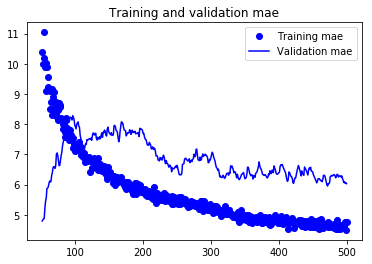

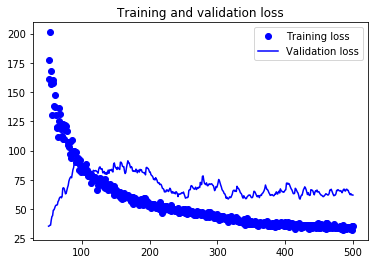

In [52]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs[50:], mae[50:], 'bo', label='Training mae')
plt.plot(epochs[50:], smooth_curve(val_mae[50:]), 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.figure()
plt.plot(epochs[50:], loss[50:], 'bo', label='Training loss')
plt.plot(epochs[50:], smooth_curve(val_loss[50:]), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()